# Business Understanding

## Project Domain

Proyek ini berada dalam domain Health and Fitness Technology, yang memanfaatkan data wearable atau tracker kebugaran untuk memberikan wawasan dan rekomendasi otomatis terkait aktivitas fisik dan kebutuhan nutrisi harian.

## Problem Statements

Banyak pengguna alat kebugaran memiliki data seperti jumlah langkah, detak jantung, dan kalori terbakar, namun tidak tahu bagaimana menginterpretasikan data tersebut untuk:

1.Menentukan jenis aktivitas fisik yang dilakukan (misal: berjalan, lari, istirahat)

2.Mendapat rekomendasi pola makan dan kebutuhan kalori sesuai aktivitas dan BMI

## Goals

1.Membangun model machine learning yang dapat memprediksi kategori aktivitas fisik berdasarkan data kebugaran harian.

2.Memberikan rekomendasi pola makan dan jumlah kalori harian secara otomatis sesuai prediksi aktivitas dan BMI pengguna.


## Solution Statements

1.Melatih model klasifikasi menggunakan data fitness_tracker.csv dengan fitur seperti langkah, detak jantung, kalori terbakar, BMI, dan waktu aktif.

2.Mengembangkan algoritma rekomendasi nutrisi berbasis logika sederhana yang mempertimbangkan hasil prediksi aktivitas dan BMI.

3.Mengintegrasikan solusi ini ke aplikasi web interaktif berbasis Streamlit agar pengguna dapat langsung menginput datanya dan menerima rekomendasi secara real-time.

# Data Understanding

## Import data dari kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bismamaulana","key":"b08d7ecf449f30bc1ca62220b999a7fc"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d fajobgiua/fitness-tracker-data

Dataset URL: https://www.kaggle.com/datasets/fajobgiua/fitness-tracker-data
License(s): apache-2.0


In [4]:
!mkdir fitness-tracker-data
!unzip fitness-tracker-data.zip -d fitness-tracker-data
!ls fitness-tracker-data

Archive:  fitness-tracker-data.zip
  inflating: fitness-tracker-data/fitness_tracker.csv  
fitness_tracker.csv


## Import Library yang dibutuhkan

In [46]:
import pandas as pd
import numpy as np
import joblib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Exploratory Data Analysis

In [40]:
df = pd.read_csv('fitness-tracker-data/fitness_tracker.csv')
df.head()

,User_ID,Steps,Heart_Rate,Calories_Burned,BMI,Workout_Intensity,Active_Minutes
0,1,11895,131,333,22.8,High,119
1,2,10618,82,759,29.4,Moderate,106
2,3,12674,130,607,26.9,High,127
3,4,19579,84,505,25.4,High,196
4,5,5156,127,433,20.3,Moderate,52


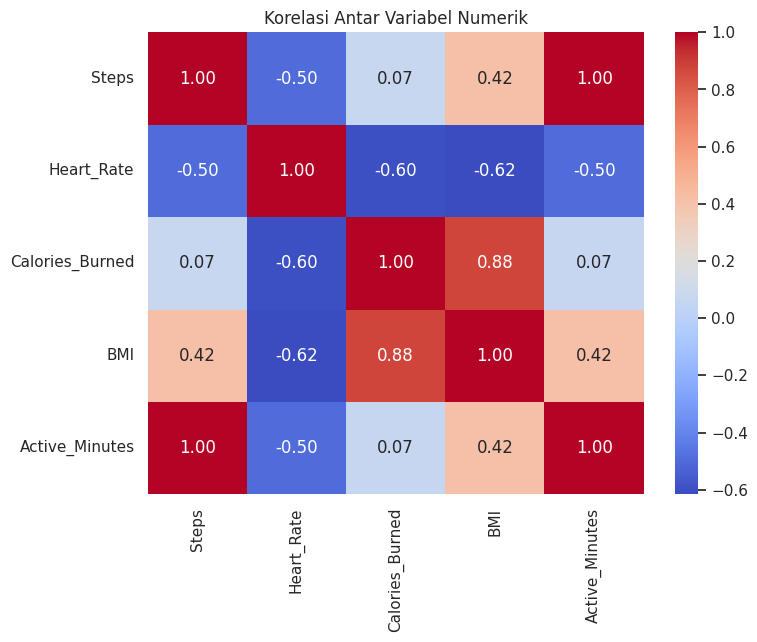

In [73]:
# Korelasi Antar Variabel Numerik
plt.figure(figsize=(8, 6))
numerical_cols = ['Steps', 'Heart_Rate', 'Calories_Burned', 'BMI', 'Active_Minutes']
corr_matrix = df[numerical_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Variabel Numerik')
plt.show()

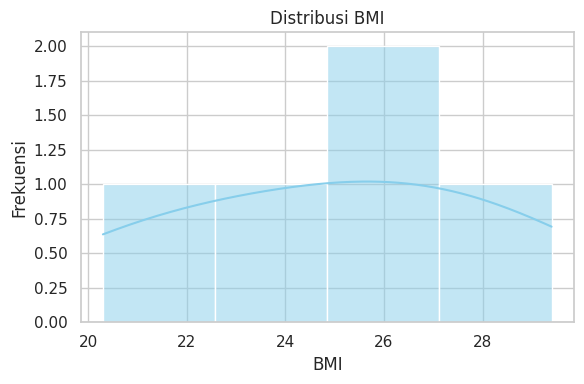

In [71]:
# Distribusi BMI
data = {
    "User_ID": [1, 2, 3, 4, 5],
    "Steps": [11895, 10618, 12674, 19579, 5156],
    "Heart_Rate": [131, 82, 130, 84, 127],
    "Calories_Burned": [333, 759, 607, 505, 433],
    "BMI": [22.8, 29.4, 26.9, 25.4, 20.3],
    "Workout_Intensity": ["High", "Moderate", "High", "High", "Moderate"],
    "Active_Minutes": [119, 106, 127, 196, 52]
}

df = pd.DataFrame(data)
sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.histplot(df["BMI"], kde=True, color="skyblue")
plt.title("Distribusi BMI")
plt.xlabel("BMI")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

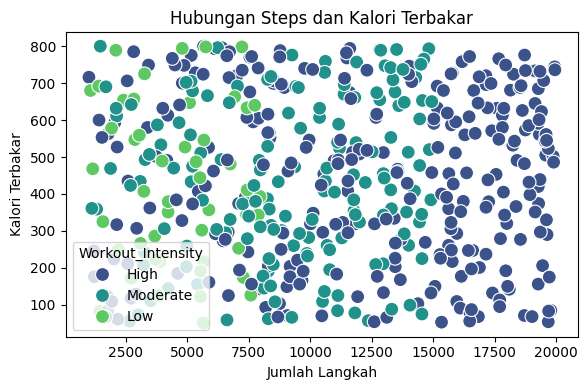

In [69]:
# Hubungan Steps dan Calories Burned
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Steps", y="Calories_Burned", hue="Workout_Intensity", palette="viridis", s=100)
plt.title("Hubungan Steps dan Kalori Terbakar")
plt.xlabel("Jumlah Langkah")
plt.ylabel("Kalori Terbakar")
plt.tight_layout()
plt.show()

<ipython-input-70-295837b6ac77>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Workout_Intensity", y="Active_Minutes", palette="coolwarm")


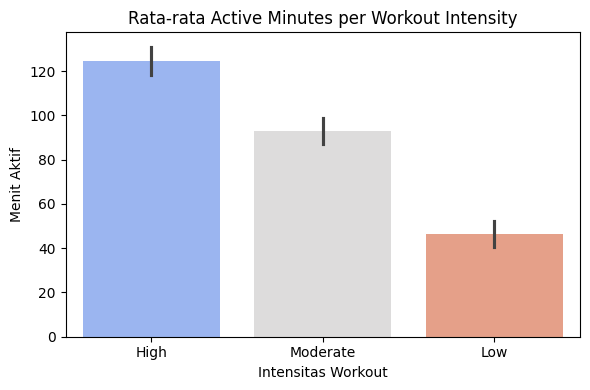

In [70]:
# Rata-rata Active Minutes berdasarkan Workout Intensity
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x="Workout_Intensity", y="Active_Minutes", palette="coolwarm")
plt.title("Rata-rata Active Minutes per Workout Intensity")
plt.xlabel("Intensitas Workout")
plt.ylabel("Menit Aktif")
plt.tight_layout()
plt.show()

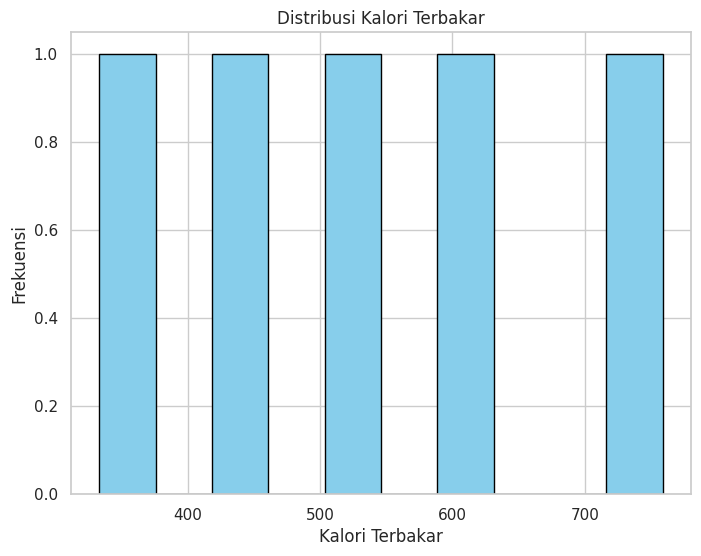

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df['Calories_Burned'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribusi Kalori Terbakar')
plt.xlabel('Kalori Terbakar')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

# Data Preparation

In [43]:
def classify_activity(row):
    if row['Steps'] > 10000 and row['Heart_Rate'] > 120:
        return "Running"
    elif row['Steps'] > 5000:
        return "Walking"
    else:
        return "Resting"

df['Activity'] = df.apply(classify_activity, axis=1)


In [44]:
X = df[['Steps', 'Heart_Rate', 'Calories_Burned', 'BMI', 'Active_Minutes']]
y = df['Activity']

In [47]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Modeling

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [50]:
model.save('activity_model.h5')


In [75]:
from google.colab import files
files.download('activity_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [52]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,563 (10.01 KB)

 Trainable params: 2,563 (10.01 KB)

 Non-trainable params: 0 (0.00 B)

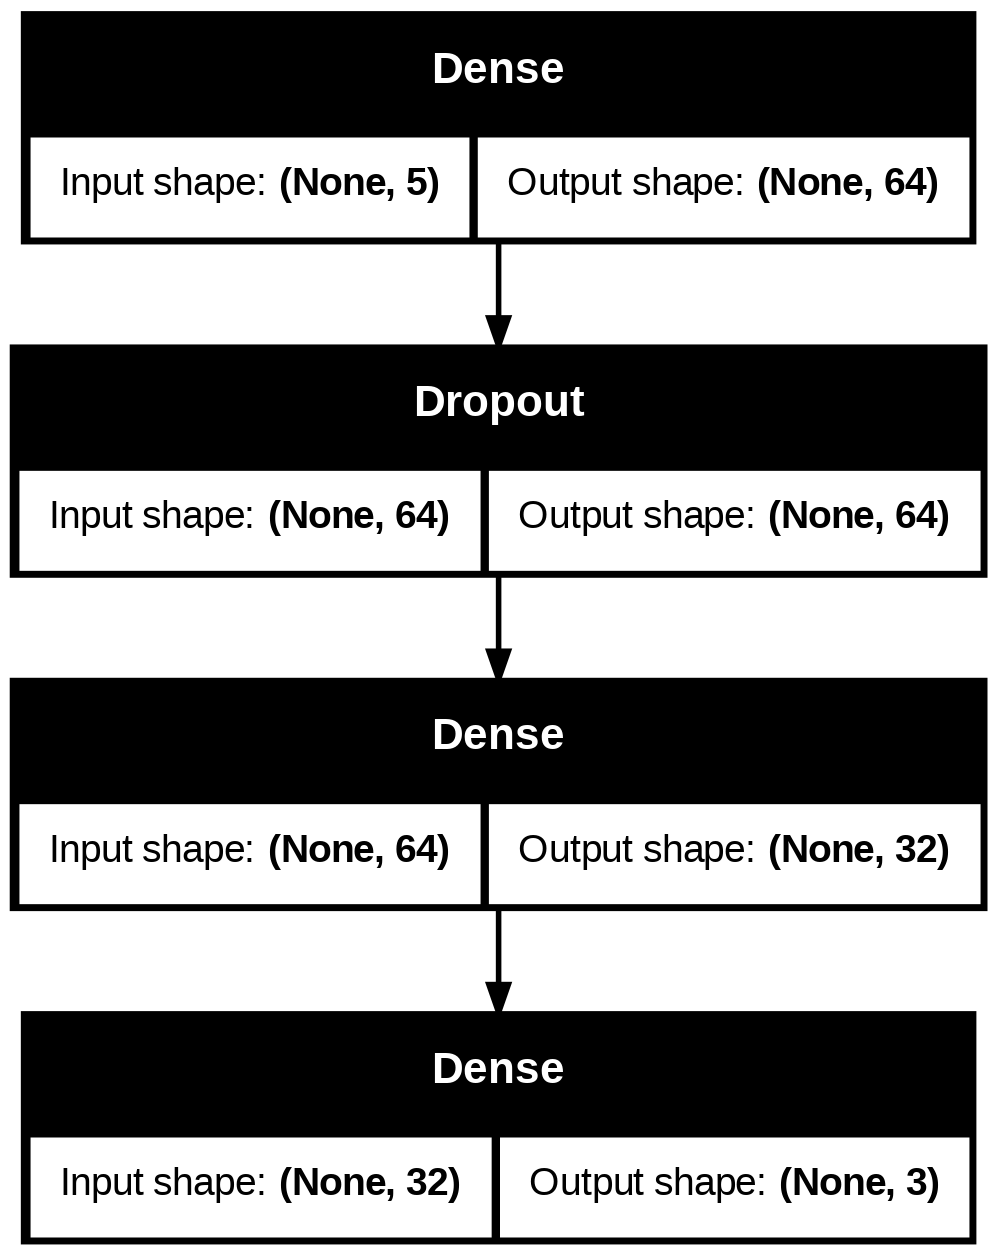

In [53]:

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

In [54]:
# Latih model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4338 - loss: 1.0770 - val_accuracy: 0.7875 - val_loss: 0.9134
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7182 - loss: 0.8756 - val_accuracy: 0.7750 - val_loss: 0.7626
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7662 - loss: 0.7465 - val_accuracy: 0.8750 - val_loss: 0.6335
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8781 - loss: 0.6085 - val_accuracy: 0.8750 - val_loss: 0.5203
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8312 - loss: 0.5291 - val_accuracy: 0.9125 - val_loss: 0.4347
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9216 - loss: 0.4329 - val_accuracy: 0.8750 - val_loss: 0.3727
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8745 - loss: 0.3854 - val_accuracy: 0.9250 - val_loss: 0.3251
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8948 - loss: 0.3400 - val_accuracy: 0.9250 - val_loss

# Evaluation

In [57]:
# Evaluasi akurasi pada data test
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 0.94
              precision    recall  f1-score   support

     Resting       0.93      0.78      0.85        18
     Running       1.00      0.96      0.98        28
     Walking       0.91      0.98      0.95        54

    accuracy                           0.94       100
   macro avg       0.95      0.91      0.93       100
weighted avg       0.94      0.94      0.94       100



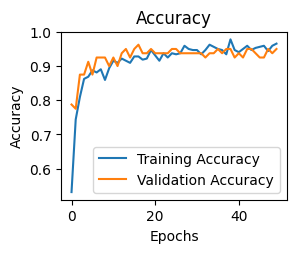

In [58]:
plt.subplot(2, 2, 4)
plt.plot(history.history["accuracy"], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

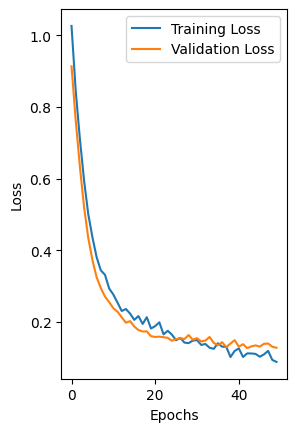

In [59]:
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

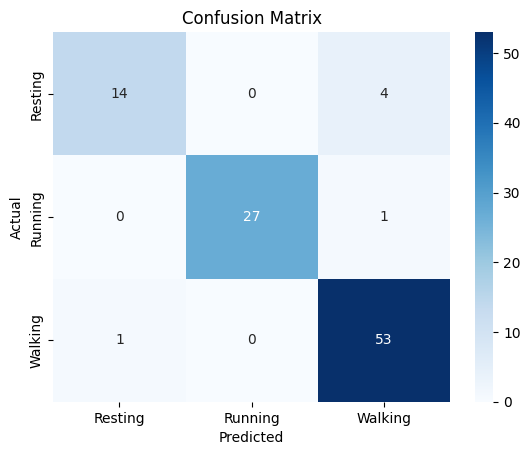

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       1.00      0.96      0.98        28
           2       0.91      0.98      0.95        54

    accuracy                           0.94       100
   macro avg       0.95      0.91      0.93       100
weighted avg       0.94      0.94      0.94       100



In [60]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred)) # Use y_pred directly

# Deployment

## Model Simulation

In [61]:
def generate_nutrition_recommendation(activity, bmi, height_cm=170):
    height_m = height_cm / 100
    weight = bmi * (height_m ** 2)

    if activity == "Running":
        diet = "Tinggi protein"
        calories = round(15 * weight + 300)
    elif activity == "Walking":
        diet = "Pola makan seimbang"
        calories = round(13 * weight + 150)
    elif activity == "Resting":
        diet = "Pola makan ringan"
        calories = round(10 * weight)
    else:
        diet = "Tidak diketahui"
        calories = round(12 * weight)
    return diet, calories


In [65]:
df.head()

,User_ID,Steps,Heart_Rate,Calories_Burned,BMI,Workout_Intensity,Active_Minutes,Activity
0,1,11895,131,333,22.8,High,119,Running
1,2,10618,82,759,29.4,Moderate,106,Walking
2,3,12674,130,607,26.9,High,127,Running
3,4,19579,84,505,25.4,High,196,Walking
4,5,5156,127,433,20.3,Moderate,52,Walking


In [66]:
# Input data manual (urutan: Steps, Heart_Rate, Calories_Burned, BMI, Active_Minutes)
sample_input = np.array([[11895, 131, 333, 22.8, 119]])
sample_df = pd.DataFrame(sample_input, columns=X.columns)
sample_scaled = scaler.transform(sample_df)

In [67]:
# Scaling
sample_input_scaled = scaler.transform(sample_df)

In [68]:
# Prediksi
prediction = model.predict(sample_scaled)
predicted_class = np.argmax(prediction, axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)[0]
diet_type, calorie_needs = generate_nutrition_recommendation(predicted_label, sample_input[0][3]) # The returned value 'diet' is assigned to 'diet_type'

print(f"🧍 Aktivitas Anda: {predicted_label}")
print(f"🍽️ Rekomendasi Pola Makan: {diet_type},Anda butuh asupan kalori {calorie_needs} kcal hari ini. ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
🧍 Aktivitas Anda: Running
🍽️ Rekomendasi Pola Makan: Tinggi protein,Anda butuh asupan kalori 1288 kcal hari ini. 


## Save Model

In [76]:
# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model
with open('Fitness_tracker.tflite', 'wb') as f:
    f.write(tflite_model)

files.download('Fitness_tracker.tflite')

Saved artifact at '/tmp/tmpj36k47pk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133568605623824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133568605624784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133568605625360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133568605626896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133568605626320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133568605627664: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
# Simpan label encoder dan scaler
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [78]:
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>